# Import and boiler plate code

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random 
import torch
from torch import autograd
import torch.nn.functional as F
import time
import math
from skimage import io,transform as sk_transform


Importing and Preparing Data

In [2]:
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
label_ids,count=np.unique(labels,return_counts=True)
print(label_ids,count)


(array([0, 1, 2, 3, 4], dtype=uint8), array([10000, 10000, 10000, 10000, 10000]))


In [3]:
shape_images_flat=(images.shape[0],images.shape[1]*images.shape[2])
images_normal=np.ndarray(shape=shape_images_flat)

# normalizing and flattening images
for index in range(len(images)):
    images_normal[index]=((images[index]-images[index].mean())/images[index].std()).flat

#  braking data set into train,validation and test sets
train_images=images_normal[0:45000]
train_labels=labels[0:45000]

validation_images=images_normal[45000:50000]
validation_labels=labels[45000:50000]

test_images=images_normal[45000:50000]
test_labels=labels[45000:50000]



In [4]:
def accuracy(y, y_hat):
    a=(y==y_hat)
    return a.astype(np.float).mean()

In [5]:
def approx_accuracy(curr_images,curr_labels,length=-1):
    if length==-1:
        length=len(curr_images)
        
    shuffle_list=np.random.choice(len(curr_images), length)
    shuffled_images=curr_images[shuffle_list]
    shuffled_labels=curr_labels[shuffle_list]
    
    x = autograd.Variable(torch.from_numpy(shuffled_images.astype(np.float32))).cuda()
    y = autograd.Variable(torch.from_numpy(shuffled_labels.astype(np.int))).cuda()
    _,y_hat =torch.max(model(x),1)
    # print(y_hat.size())
    return accuracy(y.cpu().data.numpy(), y_hat.cpu().data.numpy())
         

# Data Augmentation Code

In [6]:
def random_augment_image(images):
    
    for i in xrange(0,images.shape[0]):
        image=images[i]
        image=image.reshape(26,26)
        # print(image.shape)
        ## mirror flipping
        flip_probab = random.random()
        if flip_probab <=0.8:
            image = np.fliplr(image)

        # rotate image parmaeter:
        angle = math.radians(random.randrange(-30, +30))
        
        # translate image parameter
        tr_distance_x = random.randrange(-3, +3)
        tr_distance_y = random.randrange(-3, +3)
        # scaling image parameter
        scaling_val=random.uniform(0.7,1.3) 
        
        tform=sk_transform.SimilarityTransform(scale=scaling_val, rotation=angle,\
                                                    translation=(tr_distance_x, tr_distance_y))
        # transform probabilty 
        tr_probab= random.random()
        if tr_probab<=0.8:
            image = sk_transform.warp(image,inverse_map=tform)        
        images[i]=image.flat
    return images

In [7]:
def train(batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_images.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(random_augment_image(train_images[i]).astype(np.float32))).cuda()
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.int))).cuda()
    
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y).cuda()
    loss.backward()
    
    optimizer.step()
    return loss.data[0]


##  BEST MODEL - With Best accuracy

In [39]:
batch_size=60
learning_rate=1e-3
NUM_OPT_STEPS=30000

HEIGHT,WIDTH=26,26
NUM_CLASSES=5
NUM_HIDDEN_UNITS_1=500
NUM_HIDDEN_UNITS_2=100
# NUM_OPT_STEPS=train_labels.shape[0]/batch_size

In [40]:
#Best Model 
class Best_Model(torch.nn.Module):
    def __init__(self):
        super(Best_Model,self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3,stride=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.fc1 = torch.nn.Linear( 3200, NUM_HIDDEN_UNITS_1)
        self.fc2 = torch.nn.Linear(NUM_HIDDEN_UNITS_1, NUM_HIDDEN_UNITS_2)
        self.fc3 = torch.nn.Linear(NUM_HIDDEN_UNITS_2, NUM_CLASSES)
        self.F_max_pool2d = F.max_pool2d
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
      
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x= self.F_max_pool2d(x,3)
        x = F.relu(self.conv3(x))
        n, c, h, w = x.size()
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    

In [41]:
model=Best_Model().cuda()
print(model)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)


Best_Model (
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear (3200 -> 500)
  (fc2): Linear (500 -> 100)
  (fc3): Linear (100 -> 5)
)


In [18]:
train_accs, val_accs,test_accs = [], [] ,[]
start=time.time()

for i in range(NUM_OPT_STEPS):
    train(batch_size)    
    if i % 100 == 0:
        train_accs.append(approx_accuracy(train_images,train_labels,1000))
        val_accs.append(approx_accuracy(validation_images,validation_labels))
        test_accs.append(approx_accuracy(test_images,test_labels))
    if i%1000 == 0:
        print("%6d %5.3f %5.3f %5.3f" % ( i, train_accs[-1], val_accs[-1],test_accs[-1]))

end=time.time()
print('Time taken', end-start)

     0 0.208 0.218 0.219
  1000 0.934 0.928 0.916
  2000 0.931 0.921 0.927
  3000 0.936 0.925 0.924
  4000 0.936 0.945 0.942
  5000 0.948 0.941 0.942
  6000 0.963 0.956 0.952
  7000 0.958 0.952 0.950
  8000 0.975 0.947 0.952
  9000 0.956 0.947 0.946
 10000 0.965 0.952 0.958
 11000 0.958 0.942 0.947
 12000 0.975 0.952 0.954
 13000 0.972 0.953 0.953
 14000 0.964 0.956 0.953
 15000 0.979 0.957 0.963
 16000 0.974 0.955 0.957
 17000 0.975 0.950 0.958
 18000 0.981 0.956 0.953
 19000 0.981 0.955 0.956
 20000 0.976 0.949 0.950
 21000 0.986 0.955 0.954
 22000 0.983 0.954 0.958
 23000 0.985 0.958 0.956
 24000 0.981 0.960 0.958
 25000 0.986 0.952 0.954
 26000 0.983 0.955 0.947
 27000 0.991 0.960 0.960
 28000 0.988 0.963 0.959
 29000 0.991 0.954 0.953
('Time taken', 604.0224640369415)


 29999 0.984 0.962


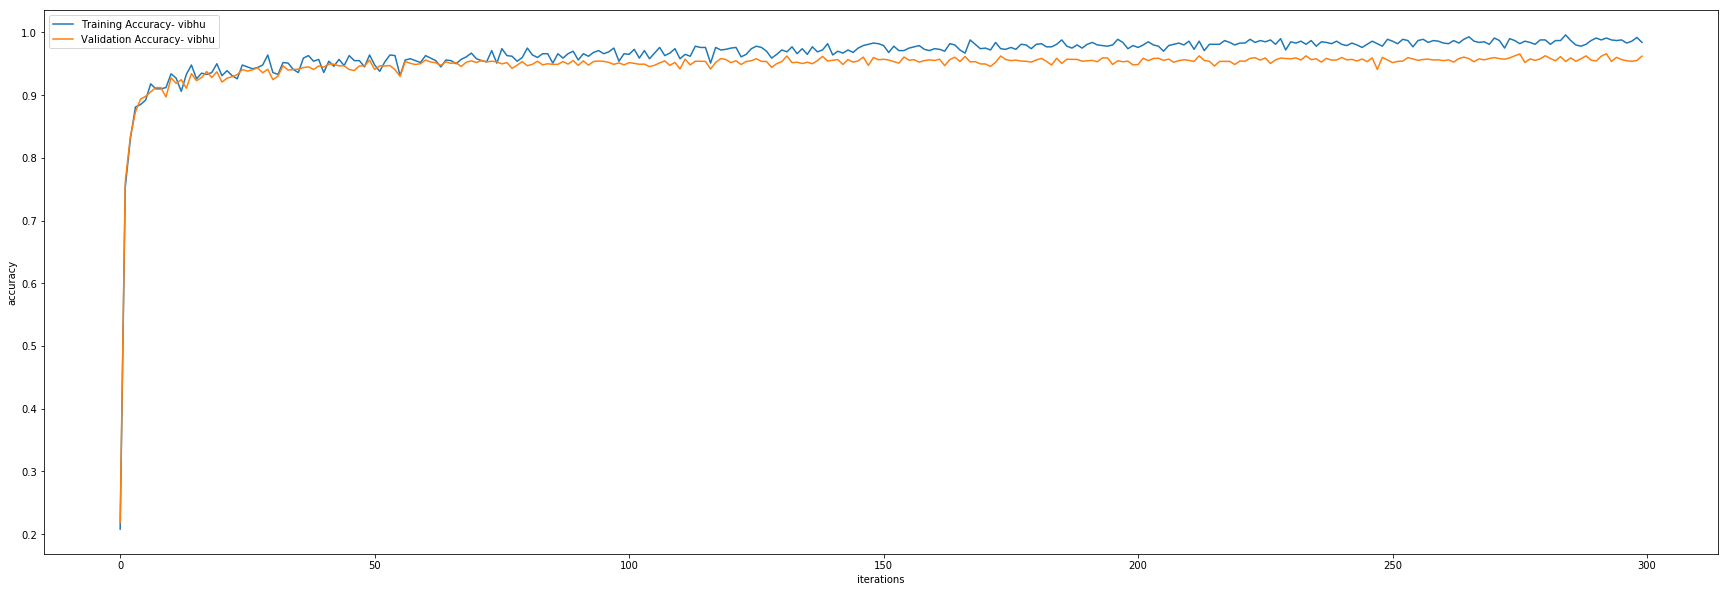

In [21]:
print("%6d %5.3f %5.3f" % ( i, train_accs[-1], val_accs[-1]))
plt.figure(figsize=(30, 10))
plt.xlabel('iterations')
plt.ylabel('accuracy')
training_accuracy_line,=plt.plot(train_accs,label='Training Accuracy- vibhu ')
validation_accuracy_line,=plt.plot(val_accs,label='Validation Accuracy- vibhu')
plt.legend(handles=[training_accuracy_line, validation_accuracy_line])

# Kaggle Prediction code

In [23]:
# Kaggle accuracy:0.95840
    
images_test_kaggle=np.load('data/part_2_test_images.npy')
shape_images_flat=(images_test_kaggle.shape[0],images_test_kaggle.shape[1]*images_test_kaggle.shape[2])
images_normal=np.ndarray(shape=shape_images_flat)

# normalizing and flattening images
for index in range(len(images_test_kaggle)):
    images_normal[index]=((images_test_kaggle[index]-images_test_kaggle[index].mean())/images_test_kaggle[index].std()).flat
x = autograd.Variable(torch.from_numpy(images_normal.astype(np.float32))).cuda()
_,y_hat =torch.max(model(x),1)
pred_numpy=y_hat.cpu().data.numpy()
np.savetxt("data/kaggle_pred_best_model.csv", np.dstack((np.arange(0, pred_numpy.size),pred_numpy))[0],"%d,%d",header="id,label")

# Best Model 2

In [8]:
batch_size=60
learning_rate=1e-3
NUM_OPT_STEPS=30000

HEIGHT,WIDTH=26,26
NUM_CLASSES=5
NUM_HIDDEN_UNITS_1=500
NUM_HIDDEN_UNITS_2=100
NUM_HIDDEN_UNITS_3=50
# NUM_OPT_STEPS=train_labels.shape[0]/batch_size

In [9]:
#Best Model2- With drop out 
class Best_Model_2(torch.nn.Module):
    def __init__(self):
        super(Best_Model_2,self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3,stride=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.fc1 = torch.nn.Linear( 3200, NUM_HIDDEN_UNITS_1)
        self.drop1 = torch.nn.Dropout(p=0.5)
        self.fc2 = torch.nn.Linear(NUM_HIDDEN_UNITS_1, NUM_HIDDEN_UNITS_2)
        self.fc3 = torch.nn.Linear(NUM_HIDDEN_UNITS_2, NUM_HIDDEN_UNITS_3)
        self.fc4 =  torch.nn.Linear(NUM_HIDDEN_UNITS_3, NUM_CLASSES)
        self.F_max_pool2d = F.max_pool2d
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
      
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x= self.F_max_pool2d(x,3)
        x = F.relu(self.conv3(x))
        n, c, h, w = x.size()
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x =self.fc4(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    

In [10]:
model=Best_Model_2().cuda()
print(model)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)


Best_Model_2 (
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear (3200 -> 500)
  (drop1): Dropout (p = 0.5)
  (fc2): Linear (500 -> 100)
  (fc3): Linear (100 -> 50)
  (fc4): Linear (50 -> 5)
)


In [11]:
train_accs, val_accs,test_accs = [], [] ,[]
start=time.time()

for i in range(NUM_OPT_STEPS):
    train(batch_size)    
    if i % 100 == 0:
        train_accs.append(approx_accuracy(train_images,train_labels,1000))
        val_accs.append(approx_accuracy(validation_images,validation_labels))
        test_accs.append(approx_accuracy(test_images,test_labels))
    if i%1000 == 0:
        print("%6d %5.3f %5.3f %5.3f" % ( i, train_accs[-1], val_accs[-1],test_accs[-1]))

end=time.time()
print('Time taken', end-start)

     0 0.189 0.203 0.213
  1000 0.903 0.909 0.918
  2000 0.929 0.923 0.924
  3000 0.942 0.933 0.929
  4000 0.953 0.936 0.936
  5000 0.935 0.936 0.942
  6000 0.955 0.938 0.936
  7000 0.960 0.944 0.941
  8000 0.941 0.949 0.943
  9000 0.960 0.944 0.945
 10000 0.960 0.947 0.951
 11000 0.966 0.951 0.948
 12000 0.969 0.948 0.945
 13000 0.962 0.952 0.954
 14000 0.971 0.946 0.947
 15000 0.962 0.948 0.945
 16000 0.958 0.953 0.951
 17000 0.966 0.946 0.940
 18000 0.976 0.954 0.955
 19000 0.967 0.961 0.957
 20000 0.957 0.955 0.953
 21000 0.960 0.953 0.951
 22000 0.967 0.952 0.954
 23000 0.968 0.957 0.957
 24000 0.978 0.949 0.955
 25000 0.965 0.955 0.954
 26000 0.969 0.952 0.952
 27000 0.976 0.956 0.952
 28000 0.971 0.950 0.959
 29000 0.971 0.956 0.952
('Time taken', 614.2730438709259)


 29999 0.976 0.954


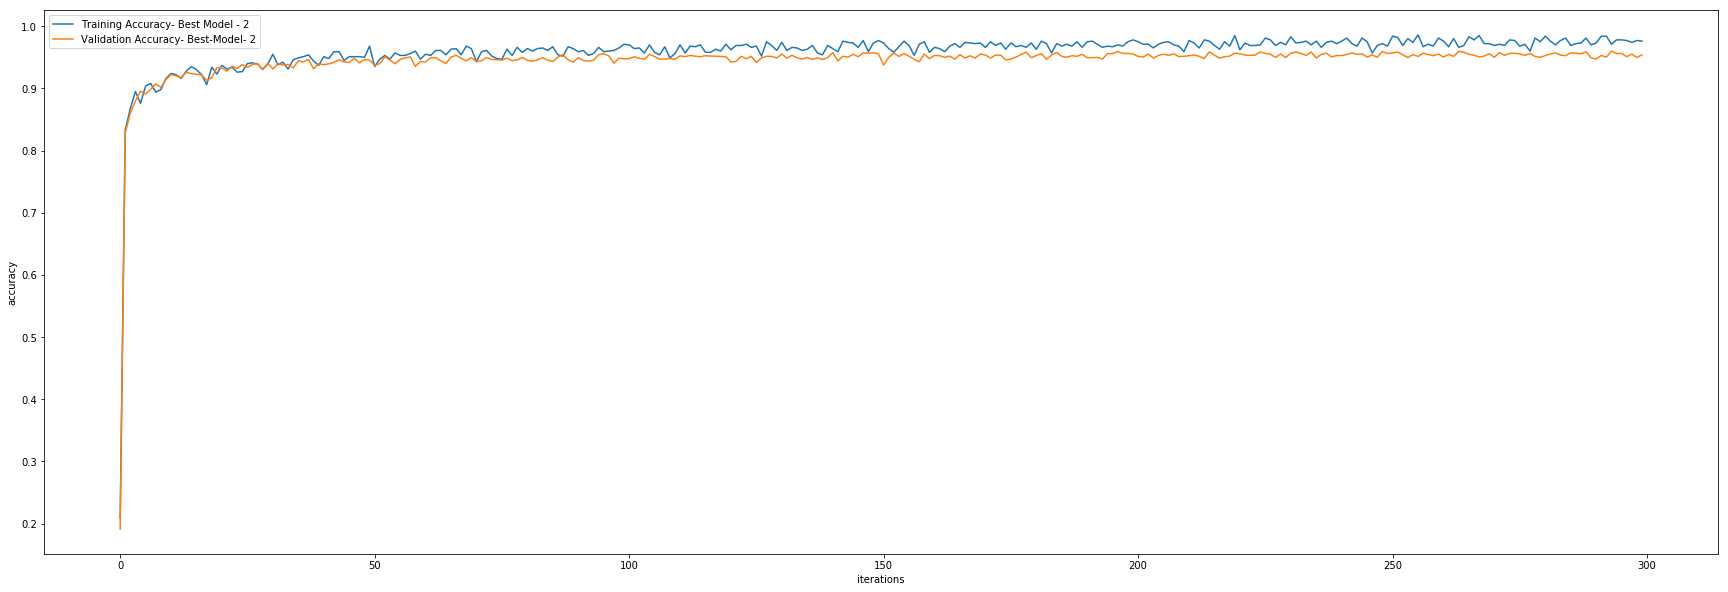

In [35]:
print("%6d %5.3f %5.3f" % ( i, train_accs[-1], val_accs[-1]))
plt.figure(figsize=(30, 10))
plt.xlabel('iterations')
plt.ylabel('accuracy')
training_accuracy_line,=plt.plot(train_accs,label='Training Accuracy- Best Model - 2 ')
validation_accuracy_line,=plt.plot(val_accs,label='Validation Accuracy- Best-Model- 2')
plt.legend(handles=[training_accuracy_line, validation_accuracy_line])

# Different Options Explored

Question: 
Explain your starting point.

What optimizer and learning rate did you settle on? 

What mini-batch size did you settle on? 

Explain what adjustments you tried to make. 

Was training too slow for any particular congurations? 

How did you circumvent this problem?

What were the most important changes for achieving high accuracy?

Describe what your finnal model is doing inplain English. This explanation will be a major part of your points for this section.



### Starting Point
I started with a networked which comprimised of 2 convolution layers and 3 Linear nn layers.
I saw that my model tended to overfit so i added drop out layers after 2 layers with probabilty of 0.2, It still seemed to overfit, so i increased the drop out probabilty of 0.8 , but then  the convergence stopped.

### Experimentations:  

    Batch normalization.
    Changing loss function to hinge.
    Added Max Pool layers
    Changed actiavtion function to selu
    Added Augmentation
    Changed Augmentation Probabilty
    Low dropout
    High Dropout


### Mini Batch Experimentations
    Batch of <40 - did not converge fast
    Batch > 80, did not give godd accuracy
    Size used = 62
    
### Slow Training:
    When i added more hidden layers > 3 , the training rate decreased by a lot.
    If i increased my learning rate to 1e-2, it did not learn
    If i decreased it to 1e-4, it was slow to converge
    

### Faster Training 
    Batch size of 62
    Removed layers 
    Made the network shallow
    Added Max-pool 2d to decreases parameters
    
    
### Most Important Changes
    Data Augmentation with random probabilty
        This prevented over fitting and made sure model did not over fit.
        Augmetations added : 
            Mirror flipping
            Rotated image (-30 to 30)
            Traslation(-3 to 3) along both axis
            Sacaled-(0.7,1.3) 
     Data Augmentation with random probabilty
     This prevented over fitting and made sure model did not over fit.
     Added Max- Pool Layer:
        Helped with over-fitting by providing an abstracted form of the representation. 
        It reduced the computational cost by reducing the number of parameters to learn  
        It also provided basic translation invariance to the internal representations
     Removing extra layers to decrease parameters to prevent overfitting
       
        

    
    

# Best Model Details

Model Details: 
    1. Layer 1 is a convolution layer, with 32 output channels and a kernel of size =3
    2. Layer 2 is relu
    3. Layer 3 is a convolution_layer, with 32 input channels and 64 output channels
    4. Layer 4 is relu
    5. Layer 5 is a maxpool2d layer with stride 3
    6. Layer 6 is Linear Neural Network Layer b/w 3200 - 500
    7. Layer 7 is relu
    8. Layer 8 i Linear Neural Network Layer 500-100
    9. Layer 9 is relu 
    10. Linear 10 Neural Network Layer that maps to 5 output classes  100-5
    
1 layer takes the input image and applies 32 different convoltions with a kenels of size 3, essentialy learning new features across 32 images after this.

3 layer is a relu to thrshold those actiavtation maps.

3  layer is also a convoltion layer with 64 output channel, does learning new features, think going from edges to 2-d shapes.

4 layer s a relu to thrshold those actiavtation maps.

5 layer is maxpool layer which  progressively reduces the  size of the representation to reduce the amount of parameters and computation in the network, and takes maximum in a 3 stride

6 layer is a single layer neural netwoek which maps the flatted input from last cnn

7 layer is rely

8 layer is again asingle layer neural netwoek which maps the last netwoek  to current network

9 is relu 

10 is final nn which maps to the output class.
    
